# Drone Trajectory Planner

In this project, we will develop the drone trajectory planner. This notebook serves as the main file for the project, where we will refer to the instructions and demonstrate our code.

Please follow week by week instructions, which includes writing the code in the `src/` folder.

In [111]:
# Import all the files and libraries required for the project
%load_ext autoreload
%autoreload 2
import copy
    
import numpy as np

from src.camera_utils import compute_image_footprint_on_surface, compute_ground_sampling_distance, project_world_point_to_image, reproject_image_point_to_world, compute_footprint_non_nadir
from src.data_model import Camera, DatasetSpec
from src.plan_computation import compute_distance_between_images, compute_speed_during_photo_capture, generate_photo_plan_on_grid, compute_time
from src.visualization import plot_photo_plan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Week 1: Introduction

No code contribution expected this week

# Week 2: Camera System Modeling and Operations

We plan to
- Model the simple pinhole camera system
- Write utility functions to
    - project a 3D world point to an image
    - Compute image footprint on a surface
    - Compute the Ground Sampling Distance

## Model the camera parameters

We want to model the following camera parameters in Python:
- focal length along x axis (in pixels)
- focal length along y axis (in pixels)
- optical center of the image along the x axis (in pixels)
- optical center of the image along the y axis (in pixels)
- Size of the sensor along the x axis (in mm)
- Size of the sensor along the y axis (in mm)
- Number of pixels in the image along the x axis
- Number of pixels in the image along the y axis

I recommend to use `dataclasses` ([Python documentation](https://docs.python.org/3/library/dataclasses.html), [Blog](https://www.dataquest.io/blog/how-to-use-python-data-classes/) to model these parameters.

$\color{red}{\text{TODO: }}$ Implement `Camera` in `src/data_model.py`

In [112]:
# Define the parameters for Skydio VT300L - Wide camera
# Ref: https://support.skydio.com/hc/en-us/articles/20866347470491-Skydio-X10-camera-and-metadata-overview
fx = 4938.56
fy = 4936.49
cx = 4095.5
cy = 3071.5
sensor_size_x_mm = 13.107 # single pixel size * number of pixels in X dimension
sensor_size_y_mm = 9.830 # single pixel size * number of pixels in Y dimension
image_size_x = 8192
image_size_y = 6144

camera_x10 = Camera(fx, fy, cx, cy, sensor_size_x_mm, sensor_size_y_mm, image_size_x, image_size_y)

In [113]:
print(f"X10 camera model: {camera_x10}")

X10 camera model: Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)


## Project 3D world points into the image


![Camera Projection](assets/image_projection.png)
Reference: [Robert Collins CSE483](https://www.cse.psu.edu/~rtc12/CSE486/lecture12.pdf)


Equations to implement:
$$ x = f_x \frac{X}{Z} $$
$$ y = f_y \frac{Y}{Z} $$
$$ u = x + c_x $$
$$ v = y + c_y $$

$\color{red}{\text{TODO: }}$ Implement function `project_world_point_to_image` in `src/camera_utils.py`

In [114]:
point_3d = np.array([25, -30, 50], dtype=np.float32)
expected_uv = np.array([6564.80, 109.60], dtype=np.float32)
uv = project_world_point_to_image(camera_x10, point_3d)

print(f"{point_3d} projected to {uv}")

assert np.allclose(uv, expected_uv, atol=1e-2)

[ 25. -30.  50.] projected to [6564.78     109.60588]


## Compute Image Footprint on the surface

We have written code to *project* a 3D point into the image. The reverse operation is reprojection, where we take $(x, y)$ and compute the $(X, Y)$ for a given value of $Z$. Note that while going from 3D to 2D, the depth becomes ambiguous so we need the to specify the $Z$.

An image's footprint is the area on the surface which is captured by the image. We can take the two corners of the image and reproject them at a given distance to obtain the width and length of the image.

$\color{red}{\text{TODO: }}$ Implement function `compute_image_footprint_on_surface` in `src/camera_utils.py`

In [115]:
footprint_at_100m = compute_image_footprint_on_surface(camera_x10, 100)
expected_footprint_at_100m = np.array([165.88, 124.46], dtype=np.float32)

print(f"Footprint at 100m = {footprint_at_100m}")

assert np.allclose(footprint_at_100m, expected_footprint_at_100m, atol=1e-2)


Footprint at 100m = [165.87831 124.4609 ]


In [116]:
footprint_at_200m = compute_image_footprint_on_surface(camera_x10, 200)
expected_footprint_at_200m = expected_footprint_at_100m * 2

print(f"Footprint at 200m = {footprint_at_200m}")

assert np.allclose(footprint_at_200m, expected_footprint_at_200m, atol=1e-2)

Footprint at 200m = [331.75662 248.9218 ]


## Ground Sampling Distance

Ground sampling distance is the length of the ground (in m) captured by a single pixel. We have the image footpring (the dimensions of ground captured by the whole sensor, and the number of pixels along the horizontal and vertical dimension. Can we get GSD from these two quantities?

In [117]:
gsd_at_100m = compute_ground_sampling_distance(camera_x10, 100)
expected_gsd_at_100m = 0.0202

print(f"GSD at 100m: {gsd_at_100m}")

assert np.allclose(gsd_at_100m, expected_gsd_at_100m, atol=1e-4)

GSD at 100m: 0.020248817469059804


## Bonus: Reprojection from 2D to 3D

If we have a 2d pixel location of a point along with the camera model, can we go back to 3D?
Do we need any additional information.


$\color{red}{\text{TODO: }}$ Implement function `reproject_image_point_to_world` in `src/camera_utils.py` and demonstrate it by running it in the notebook. Confirm that your reprojection + projection function are consistent.

We need the distance from the object in order to go from 2D to 3D.  Without this, different 3D positions are possible based on the same 2D point.

In [118]:
#using the example from above:
point_3d = np.array([25, -30, 50], dtype=np.float32)
print("3D point: " + str(point_3d))

uv = project_world_point_to_image(camera_x10, point_3d)
print("Projected 2D point: " + str(uv))

reprojected_point_3d = reproject_image_point_to_world(camera_x10, uv, point_3d[2])
print("Reprojected 3D point: " + str(reprojected_point_3d))

assert np.allclose(point_3d, reprojected_point_3d, atol=1e-4)

3D point: [ 25. -30.  50.]
Projected 2D point: [6564.78     109.60588]
Reprojected 3D point: [ 24.999998 -30.000002  50.      ]


# Week 3: Model the user requirements

For this week, we will model the dataset specifications.

- Overlap: the ratio (in 0 to 1) of scene shared between two consecutive images.
- Sidelap: the ratio (in 0 to 1) of scene shared between two images in adjacent rows.
- Height: the height of the scan above the ground (in meters).
- Scan_dimension_x: the horizontal size of the rectangle to be scanned
- Scan_dimension_y: the vertical size of the rectangle to be scanned
- exposure_time_ms: the exposure time for each image (in milliseconds).


$\color{red}{\text{TODO: }}$ Implement `DatasetSpec` in `src/data_model.py`


In [119]:
# Model the nomimal dataset spec

overlap = 0.7
sidelap = 0.7
height = 30.48 # 100 ft
scan_dimension_x = 150
scan_dimension_y = 150
exposure_time_ms = 2 # 1/500 exposure time

dataset_spec = DatasetSpec(overlap, sidelap, height, scan_dimension_x, scan_dimension_y, exposure_time_ms)

print(f"Nominal specs: {dataset_spec}")

Nominal specs: DatasetSpec(overlap=0.7, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2)


# Week 4: Compute Distance Between Photos

The overlap and sidelap are the ratio of the dimensions shared between two photos. We already know the footprint of a single image at a given distance. Can we convert the ratio into actual distances? And how does the distance on the surface relate to distance travelled by the camera?

$\color{red}{\text{TODO: }}$ Implement `compute_distance_between_images` in `src/plan_computation.py`



<h4>Can we convert the ratio into actual distances? </h4>

<p>Yes</p>

<h4>And how does the distance on the surface relate to distance travelled by the camera?</h4>

<p>The distance between images does not affect the distance travelled by the camera.  The amount of area on the surface that needs to be captured is directly proportional to the distance the camera must travel.  Increasing the frequency of images does not change the distance the camera needs to go.</p>

In [120]:
computed_distances = compute_distance_between_images(camera_x10, dataset_spec)
expected_distances = np.array([15.17, 11.38], dtype=np.float32)

print(f"Computed distance for X10 camera with nominal dataset specs: {computed_distances}")

assert np.allclose(computed_distances, expected_distances, atol=1e-2)

Computed distance for X10 camera with nominal dataset specs: [15.167913 11.380705]


$\color{red}{\text{TODO: }}$ define more specifications/camera parameters and check the computed distances. Does that align with your expections


In [121]:
print("Computed Distances:\n")

camera_ = copy.copy(camera_x10)

camera_.cx *= 2
camera_.cy *= 2
camera_.fx *= 2
camera_.fy *= 2
camera_.image_size_x_px *= 2
camera_.image_size_y_px *= 2
camera_.sensor_size_x_mm *= 2
camera_.sensor_size_y_mm *= 2

dataset_spec_ = copy.copy(dataset_spec)

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Every camera parameter doubled: {computed_distances_}")

camera_ = copy.copy(camera_x10)

dataset_spec_.overlap = 0.5

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Reduced Overlap: {computed_distances_}")

dataset_spec_.overlap = 0.9

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Increased Overlap: {computed_distances_}")

dataset_spec_.overlap = 0.7
dataset_spec_.sidelap = 0.5

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Reduced Sidelap: {computed_distances_}")

dataset_spec_.sidelap = 0.9

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Increased Sidelap: {computed_distances_}")

dataset_spec_.sidelap = 0.7
dataset_spec_.height = 20.3

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Reduced Height: {computed_distances_}")

dataset_spec_.height = 40.1

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Increased Height: {computed_distances_}")

dataset_spec_.height = 30.48
dataset_spec_.scan_dimension_x = 100
dataset_spec_.scan_dimension_y = 100

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Reduced Scan Dimmension: {computed_distances_}")

dataset_spec_.scan_dimension_x = 150
dataset_spec_.scan_dimension_y = 150
dataset_spec_.exposure_time_ms = 1

computed_distances_ = compute_distance_between_images(camera_, dataset_spec_)
print(f"Reduced Exposure Time: {computed_distances_}")

Computed Distances:

Every camera parameter doubled: [15.167913 11.380705]
Reduced Overlap: [25.279856 11.380705]
Increased Overlap: [ 5.055971 11.380705]
Reduced Sidelap: [15.167913 18.967842]
Increased Sidelap: [15.167913   3.7935684]
Reduced Height: [10.10199   7.579669]
Increased Height: [19.955162 14.972647]
Reduced Scan Dimmension: [15.167913 11.380705]
Reduced Exposure Time: [15.167913 11.380705]


These results are in general what I expected, although it was interesting to see the degree to which things changes based on changes to different parameters.

## Bonus: Non-Nadir photos

We have solved for the distance assuming that the camera is facing straight down to the ground. This is called [Nadir scanning](https://support.esri.com/en-us/gis-dictionary/nadir). However, in practise we might want a custom gimbal angle.

Your bonus task is to make the distance computation general. Introduce the `camera_angle` parameter in the dataset specification, and work out how to adapt your computation. Feel free to reach out to Ayush to discuss ideas and assumptions!

In [122]:
#no rotation
print("No Rotation:")
no_rot = compute_footprint_non_nadir(camera_x10, dataset_spec.height)
print(no_rot)

#x rotation:
print("X Rotation:")
x_rot = compute_footprint_non_nadir(camera_x10, dataset_spec.height, 20, 0)
print(x_rot)

#y rotation:
print("Y Rotation")
y_rot = compute_footprint_non_nadir(camera_x10, dataset_spec.height, 0, 20)
print(y_rot)

#2 rotations
print("Negative Rotation")
both_rot = compute_footprint_non_nadir(camera_x10, dataset_spec.height, -20, -20)
print(both_rot)

No Rotation:
[[-25.27985486  18.96784152]
 [ 25.27985486  18.96784152]
 [ 25.27985486 -18.96784152]
 [-25.27985486 -18.96784152]]
X Rotation:
[[-10.8966335   15.50469385]
 [ 52.10185461  28.91333479]
 [ 52.10185461 -28.91333479]
 [-10.8966335  -15.50469385]]
Y Rotation
[[-34.77992337  38.86446886]
 [ 34.77992337  38.86446886]
 [ 21.9341644   -6.4199158 ]
 [-21.9341644   -6.4199158 ]]
Negative Rotation
[[-41.21548476  13.24613257]
 [  9.78441149   3.7218043 ]
 [ 14.23071342 -32.64204795]
 [-84.68373051 -61.10407906]]


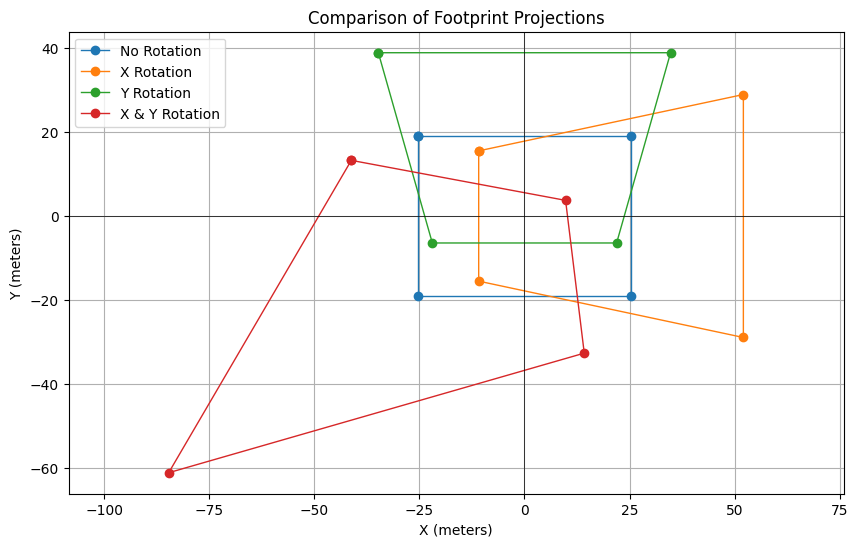

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot No Rotation
plt.plot(
    np.append(no_rot[:, 0], no_rot[0, 0]),
    np.append(no_rot[:, 1], no_rot[0, 1]),
    marker='o', label='No Rotation', linestyle='-', linewidth=1
)

# Plot X Rotation
plt.plot(
    np.append(x_rot[:, 0], x_rot[0, 0]),
    np.append(x_rot[:, 1], x_rot[0, 1]),
    marker='o', label='X Rotation', linestyle='-', linewidth=1
)

#Plot Y Rotation
plt.plot(
    np.append(y_rot[:, 0], y_rot[0, 0]),
    np.append(y_rot[:, 1], y_rot[0, 1]),
    marker='o', label='Y Rotation', linestyle='-', linewidth=1
)
#Plot X+Y Rotation
plt.plot(
    np.append(both_rot[:, 0], both_rot[0, 0]),
    np.append(both_rot[:, 1], both_rot[0, 1]),
    marker='o', label='X & Y Rotation', linestyle='-', linewidth=1
)

# Configure plot
plt.title("Comparison of Footprint Projections")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.axis('equal')

plt.show()

# Week 5: Compute Maximum Speed For Blur Free Photos

To restrict motion blur due to camera movement to tolerable limits, we need to restrict the speed such that the image contents move less than 1px away. 

How much does 1px of movement translate to movement of the scene on the ground? It is the ground sampling distance!
From previous week, we know that this is the maximum movement the camera can have. 
We have the distance now. To get speed we need to divide it with time. Do we have time already in our data models?

$\color{red}{\text{TODO: }}$ Implement `compute_speed_during_photo_capture` in `src/plan_computation.py`.

In [124]:
computed_speed = compute_speed_during_photo_capture(camera_x10, dataset_spec, allowed_movement_px=1)
expected_speed = 3.09

print(f"Computed speed during photo captures: {computed_speed:.2f}")

assert np.allclose(computed_speed, expected_speed, atol=1e-2)

Computed speed during photo captures: 3.09


$\color{red}{\text{TODO: }}$ define more specifications/camera parameters and check the computed distances. Does that align with your expections


In [125]:
print("Computed Distances:\n")

camera_ = copy.copy(camera_x10)

camera_.cx *= 2
camera_.cy *= 2
camera_.fx *= 2
camera_.fy *= 2
camera_.image_size_x_px *= 2
camera_.image_size_y_px *= 2
camera_.sensor_size_x_mm *= 2
camera_.sensor_size_y_mm *= 2

dataset_spec_ = copy.copy(dataset_spec)

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Every camera parameter doubled: {computed_distances_}")

camera_ = copy.copy(camera_x10)

dataset_spec_.overlap = 0.5

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Reduced Overlap: {computed_distances_}")

dataset_spec_.overlap = 0.9

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Increased Overlap: {computed_distances_}")

dataset_spec_.overlap = 0.7
dataset_spec_.sidelap = 0.5

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Reduced Sidelap: {computed_distances_}")

dataset_spec_.sidelap = 0.9

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Increased Sidelap: {computed_distances_}")

dataset_spec_.sidelap = 0.7
dataset_spec_.height = 20.3

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Reduced Height: {computed_distances_}")

dataset_spec_.height = 40.1

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Increased Height: {computed_distances_}")

dataset_spec_.height = 30.48
dataset_spec_.scan_dimension_x = 100
dataset_spec_.scan_dimension_y = 100

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Reduced Scan Dimmension: {computed_distances_}")

dataset_spec_.scan_dimension_x = 150
dataset_spec_.scan_dimension_y = 150
dataset_spec_.exposure_time_ms = 1

computed_distances_ = compute_speed_during_photo_capture(camera_, dataset_spec_)
print(f"Reduced Exposure Time: {computed_distances_}")

Computed Distances:

Every camera parameter doubled: 1.5429598911423572
Reduced Overlap: 3.0859197822847144
Increased Overlap: 3.0859197822847144
Reduced Sidelap: 3.0859197822847144
Increased Sidelap: 3.0859197822847144
Reduced Height: 2.0552549731095704
Increased Height: 4.059887902546492
Reduced Scan Dimmension: 3.0859197822847144
Reduced Exposure Time: 6.171839564569429


I used the same adjustments to the camera and dataspec as for part 4 to compare the differences.  I am not surprised by any of the results, but again it is interesting to see the way the numbers change based on a change in the input.  I think it's interesting to see how the same changes to input can affect the results from this week and from last week differently.

# Week 6: Generate Full Flight Plans  

We now have all the tools to generate the full flight plan.

Steps for this week:
1. Define the `Waypoint` data model. What attributes should the data model have?
   1. For Nadir scans, just the position of the camera is enough as we will always look drown to the ground.
   2. For general case (bonus), we also need to define where the drone will look at@
3. Implement the function `generate_photo_plan_on_grid` to generate the full plan.
   1. Compute the maximum distance between two images, horizontally and vertically.
   2. Layer the images such that we cover the whole scan area. Note that you need to take care when the scan dimension is not a multiple of distance between images. Example: to cover 45m length with 10m between images, we would need 4.5 images. Not possible. 4 images would not satisfy the overlap, so we should go with 5. How should we arrange 5 images in the given 45m.
   3. Assign the speed to each waypoint.

$\color{red}{\text{TODO: }}$ Implement:
- `Waypoint` in `src/data_model.py`
- `generate_photo_plan_on_grid` in `src/plan_computation.py`.

In [126]:
computed_plan = generate_photo_plan_on_grid(camera_x10, dataset_spec) 

print(f"Computed plan with {len(computed_plan)} waypoints")

Computed plan with 165 waypoints


In [127]:
MAX_NUM_WAYPOINTS_TO_PRINT = 20

for idx, waypoint in enumerate(computed_plan[:20]):
    print(f"Idx {idx}: {waypoint}")
if len(computed_plan) >= MAX_NUM_WAYPOINTS_TO_PRINT:
    print("...")

Idx 0: Waypoint(x_pos=0.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 1: Waypoint(x_pos=15.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 2: Waypoint(x_pos=30.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 3: Waypoint(x_pos=45.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 4: Waypoint(x_pos=60.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 5: Waypoint(x_pos=75.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 6: Waypoint(x_pos=90.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 7: Waypoint(x_pos=105.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 8: Waypoint(x_pos=120.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 9: Waypoint(x_pos=135.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 10: Waypoint(x_pos=150.0, y_pos=0.0, z_pos=30.48, max_speed=3.0859197822847144)
Idx 11: Waypoint(x_pos=150.0, y_pos=10.714285714285714, z_pos=30.48, max_speed=3.0859197822847

## Bonus: Time computation 

if you have some time, you can implement a time computation function. We can make the drone fly as fast as possible between photos, but make sure it can decelerate back to the required speed at the photos. Please use the following data: 
- Max drone speed: 16m/s.
- Max acceleration: 3.5 m/s^2.

Hint: you might need to use a trapezoidal speed profile

In [128]:
MAX_DRONE_SPEED = 16.0
MAX_ACC = 3.5

In [129]:
compute_time(computed_plan, MAX_ACC, MAX_DRONE_SPEED)

Time for segment 0: 2.93 seconds
Time for segment 1: 2.93 seconds
Time for segment 2: 2.93 seconds
Time for segment 3: 2.93 seconds
Time for segment 4: 2.93 seconds
Time for segment 5: 2.93 seconds
Time for segment 6: 2.93 seconds
Time for segment 7: 2.93 seconds
Time for segment 8: 2.93 seconds
Time for segment 9: 2.93 seconds
Time for segment 10: 2.47 seconds
Time for segment 11: 2.93 seconds
Time for segment 12: 2.93 seconds
Time for segment 13: 2.93 seconds
Time for segment 14: 2.93 seconds
Time for segment 15: 2.93 seconds
Time for segment 16: 2.93 seconds
Time for segment 17: 2.93 seconds
Time for segment 18: 2.93 seconds
Time for segment 19: 2.93 seconds
Time for segment 20: 2.93 seconds
Time for segment 21: 2.47 seconds
Time for segment 22: 2.93 seconds
Time for segment 23: 2.93 seconds
Time for segment 24: 2.93 seconds
Time for segment 25: 2.93 seconds
Time for segment 26: 2.93 seconds
Time for segment 27: 2.93 seconds
Time for segment 28: 2.93 seconds
Time for segment 29: 2.9

472.3374546329599

# Week 7: Visualize Flight Plans

This week, we will use a third party plotting framework called [Plotly](https://plotly.com/python/) to visualize our plans. Please follow this [tutorial](https://www.kaggle.com/code/kanncaa1/plotly-tutorial-for-beginners) to gain some basic experience with Plotly, and then come up with your own visualization function. You are free to choose to come up with your own visualization, and use something other than Plotly.

$\color{red}{\text{TODO: }}$ Implement `plot_photo_plan` in `src/visualization.py`

In [134]:
fig = plot_photo_plan(computed_plan, compute_image_footprint_on_surface(camera_x10, dataset_spec.height), MAX_ACC, MAX_DRONE_SPEED, compute_speed_during_photo_capture(camera_x10, dataset_spec))
fig.show()

$\color{red}{\text{TODO: }}$ Compute the following ablations (and any other you can think of)

1. Change overlap and confirm it affects the consecutive images
2. Change sidelap and confirm it does not affect the consecutive images
3. Change the height of the scan and document the affect on scan plans
4. Change exposure time

In [ ]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)


MAX_DRONE_SPEED = 16.0
MAX_ACC = 3.5
footprint = compute_image_footprint_on_surface(camera_x10, dataset_spec_.height)

dataset_spec_.overlap = 0.3
print(camera_, dataset_spec_)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_), footprint, MAX_ACC, MAX_DRONE_SPEED, compute_speed_during_photo_capture(camera_, dataset_spec_))
fig.show()

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144) DatasetSpec(overlap=0.3, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2)


In [ ]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)


MAX_DRONE_SPEED = 16.0
MAX_ACC = 3.5
footprint = compute_image_footprint_on_surface(camera_x10, dataset_spec_.height)

dataset_spec_.sidelap = 0.2
print(camera_, dataset_spec_)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_), footprint, MAX_ACC, MAX_DRONE_SPEED, compute_speed_during_photo_capture(camera_, dataset_spec_))
fig.show()

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144) DatasetSpec(overlap=0.7, sidelap=0.2, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2)


In [ ]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)


MAX_DRONE_SPEED = 16.0
MAX_ACC = 3.5
dataset_spec_.height = 10.2
footprint = compute_image_footprint_on_surface(camera_x10, dataset_spec_.height)

print(camera_, dataset_spec_)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_), footprint, MAX_ACC, MAX_DRONE_SPEED, compute_speed_during_photo_capture(camera_, dataset_spec_))
fig.show()

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144) DatasetSpec(overlap=0.7, sidelap=0.7, height=10.2, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2)


In [135]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)


MAX_DRONE_SPEED = 16.0
MAX_ACC = 3.5
dataset_spec_.height = 80.2
footprint = compute_image_footprint_on_surface(camera_x10, dataset_spec_.height)

print(camera_, dataset_spec_)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_), footprint, MAX_ACC, MAX_DRONE_SPEED, compute_speed_during_photo_capture(camera_, dataset_spec_))
fig.show()

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144) DatasetSpec(overlap=0.7, sidelap=0.7, height=80.2, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2)


In [ ]:
camera_ = copy.deepcopy(camera_x10)
dataset_spec_ = copy.deepcopy(dataset_spec)


MAX_DRONE_SPEED = 16.0
MAX_ACC = 3.5

footprint = compute_image_footprint_on_surface(camera_x10, dataset_spec_.height)

dataset_spec_.exposure_time_ms = 3000

print(camera_, dataset_spec_)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera_, dataset_spec_), footprint, MAX_ACC, MAX_DRONE_SPEED, compute_speed_during_photo_capture(camera_, dataset_spec_))
fig.show()

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144) DatasetSpec(overlap=0.7, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=3000)
